## Measuring the impact of food policies on population health

An ideal population health outcome metric should reflect a population’s dynamic state of physical, mental, and social well-being. Positive health outcomes include being alive; functioning well mentally, physically, and socially; and having a sense of well-being. Negative outcomes include death, loss of function, and lack of well-being. In contrast to these health outcomes, diseases and injuries are intermediate factors that influence the likelihood of achieving a state of health. On the basis of a review of outcomes metrics currently in use and the availability of data for at least some US counties, I recommend the following metrics for population health outcomes: 1) life expectancy from birth, or age-adjusted mortality rate; 2) condition-specific changes in life expectancy, or condition-specific or age-specific mortality rates; and 3) self-reported level of health, functional status, and experiential status. When reported, outcome metrics should present both the overall level of health of a population and the distribution of health among different geographic, economic, and demographic groups in the population.

In [330]:
import bokeh
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.palettes import small_palettes as small_palettes
from bokeh.plotting import figure
from bokeh.models import CustomJS, Slider, Legend, LegendItem
from bokeh.layouts import row, widgetbox
from bokeh.sampledata.us_states import data as states
from bokeh.models import LinearColorMapper, LinearScale, ColorBar

import csv
import sqlite3
import pandas as pd
import numpy as np
import math
import matplotlib

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import interactive

matplotlib.use("svg")

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

output_notebook()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda/lib/python3.6/site-pack

Loading BokehJS ...

In [2]:
import itertools
def color_gen():
    for c in itertools.cycle(Category10[10]):
        yield c
color = color_gen()

In [4]:
datadir = "../data/"

In [59]:
!ls -lrt ../data

total 369776
-rw-r--r--@ 1 rohansingh  staff  81131198 Mar  9 08:49 FeedGrains.csv
-rw-r--r--@ 1 rohansingh  staff   4773458 Apr 12 00:18 FeedGrains.zip
-rw-r--r--  1 rohansingh  staff  79233024 Apr 12 00:28 feedgrain.db
-rw-r--r--  1 rohansingh  staff         0 Apr 12 01:01 FeedGrains.db
-rw-r--r--@ 1 rohansingh  staff    151999 Apr 16 21:47 Analysis_Tableau.twb
-rw-r--r--@ 1 rohansingh  staff     64517 Apr 16 22:30 Analysis_Tableau_AdCampaign.twb
-rw-r--r--@ 1 rohansingh  staff     37081 Apr 24 20:27 tax_per_operation_by_state_corn.csv
-rw-r--r--@ 1 rohansingh  staff   1607687 May  6 18:16 death_rate_data_1999_2016.txt
-rw-r--r--@ 1 rohansingh  staff     49268 May  6 18:34 death_rate_by_state_year.txt
-rw-r--r--@ 1 rohansingh  staff     50546 May  6 19:21 death_nutrional_endocrine_by_state_year.txt
-rw-r--r--@ 1 rohansingh  staff  20397291 May  8 10:24 nutrition_physical_activity_raw.csv
-rw-r--r--  1 rohansingh  staff     58833 May  8 10:31 obesity_data_by_state_year.csv


In [6]:
!head -1 ../data/death_rate_by_state_year.txt

### Cleaning the data retrieved from CDC website.

In [7]:
def clean_data(filename, **kwargs):
    """
    Takes a filenane to generate clean data for data retrieved from CDC.
    Args:
        filename : Raw filename downloaded from CDC website
        **kwargs['remove_cols'] : Columns that need to dropped
    Returns:
        df : clean dataframe
    """
    
    df = pd.read_csv(datadir + filename, sep="\t")
    df = df[df['Notes'].isnull()]
    df = df.drop('Notes', axis=1)
    df = df.drop(kwargs['remove_cols'], axis=1)
    # death_rate_data = death_rate_data[death_rate_data['Crude Rate'] != 'Unreliable']
    df['Crude Rate'] = df['Crude Rate'].astype(float)
    df['Year'] = df['Year'].astype(int)
    return df

### Death rate by state

We see here that the death rate across states have been fairly constant over the years for all the states. 

In [293]:
death_rate_state_year = clean_data('death_rate_by_state_year.txt', remove_cols=['State Code', 'Year Code'])

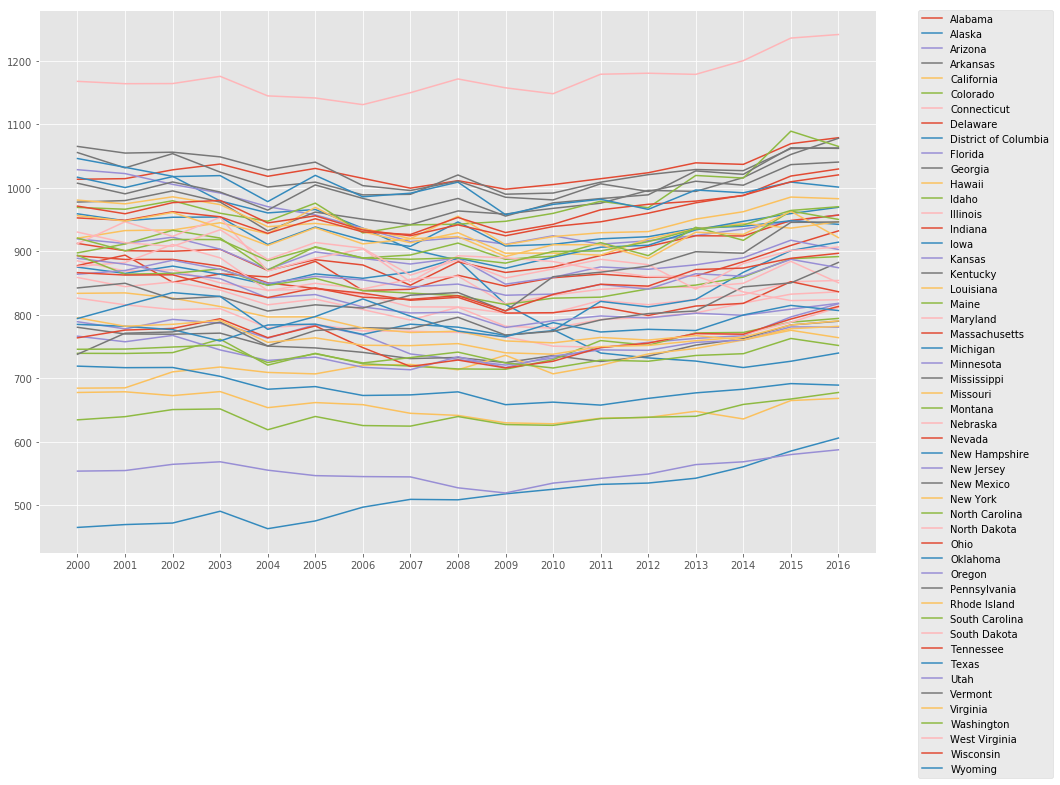

In [299]:
plot_all_states(death_rate_state_year)

### Death rate by nutrional and endocrine by state

As we wanted to analyze the effect of agricultural and food policies on the population health. We got the data regarding the deaths caused by endocrine or nutrition related problems to better understand the problem at hand.

Here we observed that the data shows a lot of variations amongst states which conforms to our assumption that obesity and obesity related deaths have been on  rise 

In [379]:
death_nutritional_state_year = clean_data('death_nutrional_endocrine_by_state_year.txt', 
                                          remove_cols=['State Code', 'Year Code'])

### See death rates for each state due to nutrional issues (broad category)

,Year,State,Deaths,Population,Crude Rate
0,2000,Alabama,45061.0,4447100.0,1013.3
1,2000,Alaska,2914.0,626932.0,464.8
2,2000,Arizona,40475.0,5130632.0,788.9
3,2000,Arkansas,28216.0,2673400.0,1055.4
4,2000,California,229443.0,33871648.0,677.4


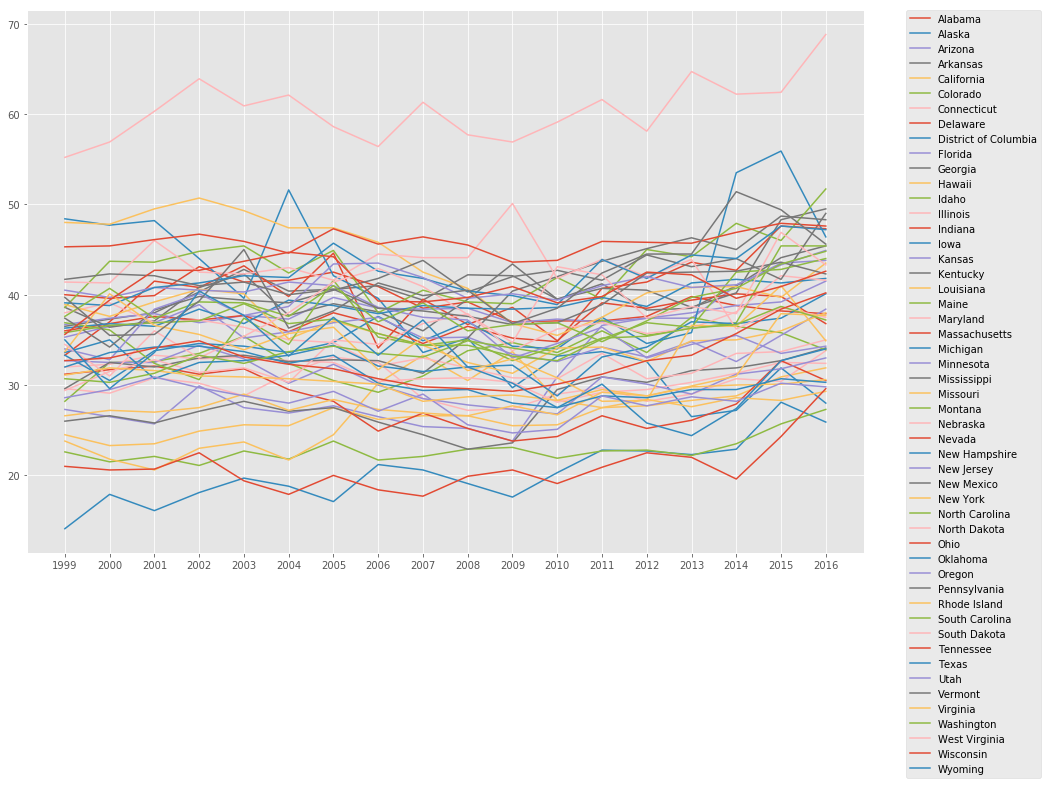

In [380]:
def plot_all_states(df):
    legend = []
    plt.figure(figsize=(15,10))
    for state in df['State'].unique():
        df1 = df[df['State'] == state]
        plt.plot(df1['Year'], df1['Crude Rate'])
        legend.append(state)
    plt.xticks(df['Year'].unique())
    plt.legend(legend,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot_all_states(death_nutritional_state_year)
death_rate_state_year.head()

### Widget to plot each state separately

In [296]:
legend = []
def plot_state(df,state):
    min_cr = min(df['Crude Rate'])
    max_cr = max(df['Crude Rate'])
    df1 = df[df['State'] == state]
    plt.plot(df1['Year'], df1['Crude Rate'])
    plt.legend([state])
    plt.xlim(2000,2016)
    plt.ylim(min_cr,max_cr)
    plt.show()
    

### View death rate by state

In [300]:
l = [(k,k) for k in death_rate_state_year['State'].unique()]
w = widgets.Select(options=l,description='Select State:')
state = 'Alabama'
    
interactive_plot = interactive(plot_state, df=fixed(death_rate_state_year),state=l)
interactive_plot

### View deaths due to nutrition (broad category) 

In [301]:
l = [(k,k) for k in death_nutritional_state_year['State'].unique()]
w = widgets.Select(options=l,description='Select State:')
state = 'Alabama'
    
interactive_plot = interactive(plot_state, df=fixed(death_nutritional_state_year),state=l)
interactive_plot

## Visualize state wise data on static map

In [302]:
def plot_on_map(df, max_rate=0, min_rate=100,year=2015):
    """
    Plot CDC Data on the an interactive US MAP
    """
    
    EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")
    color_mapper = LinearColorMapper(palette=palette, high=max_rate, low=min_rate)
    
    for state in EXCLUDED:
        if state.upper() in states:
            del states[state.upper()]
            
#     palette.reverse()
    state_codes = {
        code: state for code, state in states.items() if state not in EXCLUDED
    }

    state_xs = [states[code]["lons"] for code in state_codes]
    state_ys = [states[code]["lats"] for code in state_codes]
    state_names = [state['name'] for state in state_codes.values()]
    color_mapper = LinearColorMapper(palette=palette, high=max_rate, low=min_rate)

    state_rates = [df[(df['State']==state_codes[state_id]['name']) 
                                   & (df['Year']==year)]['Crude Rate'] for state_id in state_codes]

    dummy = np.random.randn(len(state_rates))
    years1 = pd.DataFrame({'year': str(year) , 'dummy': dummy})
    years1 = years1.drop(['dummy'], axis=1)
    years1 = years1['year']

    source = ColumnDataSource(data=dict(
        x=state_xs,
        y=state_ys,
        name=state_names,
        rate=state_rates,
        year = years1
    ))

    TOOLS = "pan,wheel_zoom,reset,hover,save"
    
    p = figure(
        title="State-wise crude death rates {}".format(year),tools=TOOLS,
        x_axis_location=None, y_axis_location=None, plot_width=250, plot_height=250
        
    )
    p.grid.grid_line_color = None

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Name", "@name"),
        ("Crude Death Rate", "@rate"),
        ("Year", "@year"),
    ]
    
    return p


In [353]:
def plot_on_map_with_slider(df, max_rate, min_rate):
    """
    Plot CDC Data on the US Map with year slider
    """
    small_palettes['Reds'][9].reverse()
    EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")
    
    for state in EXCLUDED:
        if state.upper() in states:
            del states[state.upper()]
            
    states_dict = {
        code: state for code, state in states.items() if str(state).lower() not in EXCLUDED
    }
    state_xs = [states_dict[code]["lons"] for code in states_dict]
    state_ys = [states_dict[code]["lats"] for code in states_dict]
    
    state_names = [state['name'] for state in states_dict.values()]
    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], high=max_rate, low=min_rate)

    sources = {}
    years = list(df['Year'])
    for year in years:
        x = state_xs,
        y = state_ys,
        name = state_names,
    
#     state_rates_1999 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==1999)]['Crude Rate'] for state_id in states]
#     state_rates_2000 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2000)]['Crude Rate'] for state_id in states]
#     state_rates_2001 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2001)]['Crude Rate'] for state_id in states]
#     state_rates_2002 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2002)]['Crude Rate'] for state_id in states]
#     state_rates_2003 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2003)]['Crude Rate'] for state_id in states]
#     state_rates_2004 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2004)]['Crude Rate'] for state_id in states]
#     state_rates_2005 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2005)]['Crude Rate'] for state_id in states]
#     state_rates_2006 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2006)]['Crude Rate'] for state_id in states]
#     state_rates_2007 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2007)]['Crude Rate'] for state_id in states]
#     state_rates_2008 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2008)]['Crude Rate'] for state_id in states]
#     state_rates_2009 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2009)]['Crude Rate'] for state_id in states]
#     state_rates_2010 = [df[(df['State']==states[state_id]['name']) 
#                                    & (df['Year']==2010)]['Crude Rate'] for state_id in states]
    state_rates_2011 = [df[(df['State']==states[state_id]['name']) 
                                   & (df['Year']==2011)]['Crude Rate'] for state_id in states]
    state_rates_2012 = [df[(df['State']==states[state_id]['name']) 
                                   & (df['Year']==2012)]['Crude Rate'] for state_id in states]
    state_rates_2013 = [df[(df['State']==states[state_id]['name']) 
                                   & (df['Year']==2013)]['Crude Rate'] for state_id in states]
    state_rates_2014 = [df[(df['State']==states[state_id]['name']) 
                                   & (df['Year']==2014)]['Crude Rate'] for state_id in states]
    state_rates_2015 = [df[(df['State']==states[state_id]['name']) 
                                   & (df['Year']==2015)]['Crude Rate'] for state_id in states]
    state_rates_2016 = [df[(df['State']==states[state_id]['name']) 
                                   & (df['Year']==2016)]['Crude Rate'] for state_id in states]

    source = ColumnDataSource(data=dict(
        x=state_xs,
        y=state_ys,
        name=state_names,
        rate=state_rates_2011,
#         rate=df['Crude Rate'],
#         rate_2000=state_rates_2000,
#         rate_2001=state_rates_2001,
#         rate_2002=state_rates_2002,
#         rate_2003=state_rates_2003,
#         rate_2004=state_rates_2004,
#         rate_2005=state_rates_2005,
#         rate_2006=state_rates_2006,
#         rate_2007=state_rates_2007,
#         rate_2008=state_rates_2008,
#         rate_2009=state_rates_2009,
#         rate_2010=state_rates_2010,
        rate_2011=state_rates_2011,
        rate_2012=state_rates_2012,
        rate_2013=state_rates_2013,
        rate_2014=state_rates_2014,
        rate_2015=state_rates_2015,
        rate_2016=state_rates_2016
    ))

    TOOLS = "pan,wheel_zoom,reset,hover,save"

    p = figure(
        title="Nutrition Related Deaths", tools=TOOLS,
        x_axis_location=None, y_axis_location=None
    )
    p.grid.grid_line_color = None

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], low=min_rate, high=max_rate)
    color_bar = ColorBar(color_mapper=color_mapper, 
                 label_standoff=12, border_line_color=None, location=(0,0))
    p.add_layout(color_bar, 'right')
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
#     hover.tooltips = [
#         ("Name", "@name"),
#         ("Crude Death Rate", "@rate_"+ str(year))]
    
    callback = CustomJS(args=dict(source=source), code="""
        var year = year.value;
        var data = source.data;
        var col = 'rate_' + year
        data['rate'] = data[col]
        source.change.emit();
    """)
    
    
    year_slider = Slider(start=2011, end=years[-1], value=years[0], step=1,
                        title="Year", callback=callback)
    callback.args["year"] = year_slider

    layout = row([p,year_slider])

    show(layout)


In [355]:
max_cr = max(death_nutritional_state_year['Crude Rate'])
min_cr = min(death_nutritional_state_year['Crude Rate'])
plot_on_map_with_slider(death_nutritional_state_year, max_cr, min_cr)

## Obesity Data

### Analyse the obesity data

In [61]:
raw_obestity = pd.read_csv(datadir + 'nutrition_physical_activity_raw.csv')

### Get obesity data for US and states

In [227]:
### DO NOT CHANGE THIS CELL ###
def clean_obesity(df):

    df = df[df['Data_Value_Footnote'].isnull()]

    df = df.drop(["YearEnd", 'Datasource', 'Class', 'Topic', 'Data_Value_Unit','Data_Value_Type',
                    'Data_Value_Alt', 'Data_Value_Footnote', 'Data_Value_Footnote_Symbol','Low_Confidence_Limit',
                     'High_Confidence_Limit ', 'Sample_Size', 'GeoLocation','ClassID','TopicID',
                      'DataValueTypeID','LocationID'], axis = 1)
    df_us = df[df['Total'] == 'Total']
    df_states = df[df['Total'] != 'Total']
    return df_us, df_states
obesity_us, obesity_states = clean_obesity(raw_obestity)
print(len(obesity_us))
print(len(obesity_states))
obesity_states.head(1)

1907
46439


,YearStart,LocationAbbr,LocationDesc,Question,Data_Value,Total,Age(years),Education,Gender,Income,Race/Ethnicity,QuestionID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
1,2011,AL,Alabama,Percent of adults aged 18 years and older who ...,32.3,NaN,NaN,NaN,Male,NaN,NaN,Q036,Gender,Male,GEN,MALE


### Get mappings

In [228]:
question_map = dict(zip(obesity_states['QuestionID'],obesity_states['Question']))
obesity_states_features = obesity_states.drop(['Question', 'Total'], axis = 1)
question_map

{'Q018': 'Percent of adults who report consuming fruit less than one time daily',
 'Q019': 'Percent of adults who report consuming vegetables less than one time daily',
 'Q036': 'Percent of adults aged 18 years and older who have obesity',
 'Q037': 'Percent of adults aged 18 years and older who have an overweight classification',
 'Q043': 'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
 'Q044': 'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week',
 'Q045': 'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combin

### Create features

In [229]:
obesity_without_states = obesity_states_features.drop(['StratificationCategory1', 'Stratification1',
                                                       'StratificationCategoryId1', 'StratificationID1', 
                                                       'LocationDesc', 'YearStart' , 'LocationAbbr'], axis=1)
obesity_states_features = obesity_states_features.drop(['StratificationCategory1', 'Stratification1',
                                                        'StratificationCategoryId1', 'StratificationID1', 
                                                        'LocationDesc'], axis=1)


In [230]:
obesity_features = pd.get_dummies(obesity_states_features)
obesity_features_without_year = obesity_features.drop(['YearStart'], axis=1)
obesity_features_without_year.head()

,Data_Value,LocationAbbr_AK,LocationAbbr_AL,LocationAbbr_AR,LocationAbbr_AZ,LocationAbbr_CA,LocationAbbr_CO,LocationAbbr_CT,LocationAbbr_DC,LocationAbbr_DE,...,Race/Ethnicity_Other,QuestionID_Q018,QuestionID_Q019,QuestionID_Q036,QuestionID_Q037,QuestionID_Q043,QuestionID_Q044,QuestionID_Q045,QuestionID_Q046,QuestionID_Q047
1,32.3,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,31.8,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,33.6,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,32.8,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,33.8,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [234]:
from sklearn.ensemble import RandomForestClassifier
regr = RandomForestClassifier(max_depth=2, random_state=0)
regr.fit(X, y)
print(X.columns[np.nonzero(regr.feature_importances_)])
regr.score(X,y)

Index(['LocationAbbr_AR', 'LocationAbbr_AZ', 'LocationAbbr_CA',
       'LocationAbbr_RI', 'LocationAbbr_WV', 'Age(years)_18 - 24',
       'Age(years)_55 - 64', 'Education_High school graduate', 'Gender_Female',
       'Income_Less than $15,000',
       'Race/Ethnicity_American Indian/Alaska Native', 'Race/Ethnicity_Asian',
       'Race/Ethnicity_Hawaiian/Pacific Islander', 'Race/Ethnicity_Hispanic',
       'QuestionID_Q018', 'QuestionID_Q019', 'QuestionID_Q036',
       'QuestionID_Q037', 'QuestionID_Q043', 'QuestionID_Q044',
       'QuestionID_Q046', 'QuestionID_Q047'],
      dtype='object')


0.76590796528779692

### Only demographic features

In [235]:
from sklearn.ensemble import RandomForestClassifier
def rndm_forest_non_state(df):
    df = pd.get_dummies(df)
    df = df.drop(['QuestionID_Q036','QuestionID_Q037','QuestionID_Q047','QuestionID_Q043','QuestionID_Q046',
                 'QuestionID_Q044','QuestionID_Q046'],axis=1)
    X = df.loc[:, df.columns != 'Data_Value']
    y = df.loc[:,'Data_Value'] 
    
    y = y.apply(lambda x: 0 if x<y.mean() else 1)
    regr = RandomForestClassifier(max_depth=3, random_state=0)
    regr.fit(X, y)
    l_ = regr.feature_importances_
    idx = np.argpartition(l_, -7)[-7:]
    print(X.columns[idx])
    print(regr.score(X,y))
    
rndm_forest_non_state(obesity_without_states_features)

Index(['Age(years)_18 - 24', 'Race/Ethnicity_Asian', 'Gender_Female',
       'Education_Less than high school', 'QuestionID_Q018', 'QuestionID_Q019',
       'QuestionID_Q045'],
      dtype='object')
0.602338551648


In [378]:
from sklearn.linear_model import LogisticRegression
def log_ref_non_state(df):
    df = pd.get_dummies(df)
    df = df.drop(['QuestionID_Q036','QuestionID_Q037','QuestionID_Q047','QuestionID_Q043','QuestionID_Q046',
                 'QuestionID_Q044','QuestionID_Q046'],axis=1)
    X = df.loc[:, df.columns != 'Data_Value']
    y = df.loc[:,'Data_Value'] 
    
    y = y.apply(lambda x: 0 if x<y.mean() else 1)
    regr = LogisticRegression()
    regr.fit(X, y)
    l_ = regr.coef_
    idx = np.argpartition(l_, -7)[-7:]
    print(X.columns[idx])
    print(regr.score(X,y))
log_ref_non_state(obesity_without_states_features)

Index([['Age(years)_25 - 34', 'Age(years)_18 - 24', 'QuestionID_Q019', 'Race/Ethnicity_Other', 'Race/Ethnicity_Non-Hispanic White', 'Age(years)_65 or older', 'Education_College graduate', 'Race/Ethnicity_Asian', 'Income_Data not reported', 'Income_$75,000 or greater', 'Gender_Female', 'Income_$50,000 - $74,999', 'Income_$35,000 - $49,999', 'Race/Ethnicity_2 or more races', 'Income_$25,000 - $34,999', 'Age(years)_35 - 44', 'Education_Some college or technical school', 'Race/Ethnicity_Hispanic', 'QuestionID_Q045', 'Gender_Male', 'Age(years)_45 - 54', 'Education_High school graduate', 'Age(years)_55 - 64', 'Race/Ethnicity_Hawaiian/Pacific Islander', 'Income_Less than $15,000', 'Race/Ethnicity_American Indian/Alaska Native', 'Education_Less than high school', 'QuestionID_Q018', 'Income_$15,000 - $24,999', 'Race/Ethnicity_Non-Hispanic Black']], dtype='object')
0.608303365706


In [ ]:
plt.hist(obesity_states_features[obesity_states_features['Age(years)'] == 'Female']['Data_Value'],bins=20)

[nan '18 - 24' '25 - 34' '35 - 44' '45 - 54' '55 - 64' '65 or older']


(array([   2.,   10.,   38.,  105.,  168.,  198.,  265.,  439.,  297.,
         137.,   50.,   24.,   27.,   35.,   39.,   20.,   29.,   18.,
           4.,    2.]),
 array([  6.4 ,   9.35,  12.3 ,  15.25,  18.2 ,  21.15,  24.1 ,  27.05,
         30.  ,  32.95,  35.9 ,  38.85,  41.8 ,  44.75,  47.7 ,  50.65,
         53.6 ,  56.55,  59.5 ,  62.45,  65.4 ]),
 <a list of 20 Patch objects>)

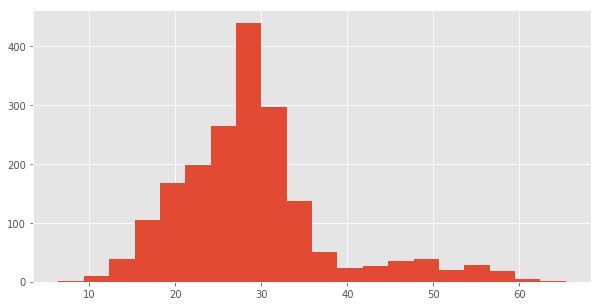

In [226]:
print(obesity_states_features['Age(years)'].unique())
plt.hist(obesity_states_features[obesity_states_features['Gender'] == 'Female']['Data_Value'],bins=20)

(array([   2.,   12.,   41.,  108.,  179.,  217.,  209.,  193.,  144.,
         108.,  119.,  210.,  140.,   55.,   46.,   43.,   39.,   26.,
          12.,    4.]),
 array([ 10.1 ,  12.79,  15.48,  18.17,  20.86,  23.55,  26.24,  28.93,
         31.62,  34.31,  37.  ,  39.69,  42.38,  45.07,  47.76,  50.45,
         53.14,  55.83,  58.52,  61.21,  63.9 ]),
 <a list of 20 Patch objects>)

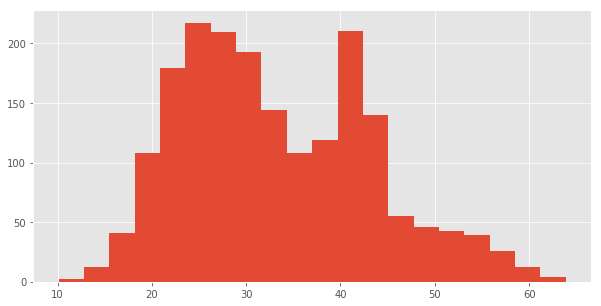

In [210]:
plt.hist(obesity_states_features[obesity_states_features['Gender'] == 'Male']['Data_Value'],bins=20)

### Corn Price Analysis


In [217]:
corn_prices = pd.read_csv(datadir + 'corn_prices_by_state.csv')
corn_prices = corn_prices.drop(['Program', 'State ANSI', 'Data Item'], axis = 1)
corn_prices.columns = ['Year', 'State', 'Crude Rate']
corn_prices.head()

,Year,State,Crude Rate
0,2017,ALABAMA,4.00
1,2017,ARIZONA,4.35
2,2017,ARKANSAS,3.50
3,2017,CALIFORNIA,4.20
4,2017,COLORADO,3.35


(array([  1.,   0.,   2.,   2.,   0.,   0.,   2.,   6.,   7.,   6.,   6.,
          2.,   4.,   5.,   4.,  12.,   8.,   9.,   8.,  11.,  15.,   4.,
          8.,   7.,   5.,   8.,   4.,   5.,   3.,   5.,   3.,   6.,   3.,
          3.,   1.,   7.,   7.,   0.,   3.,   1.,   4.,   4.,   3.,   6.,
          3.,   4.,   2.,   3.,   2.,   3.,   1.,   3.,   1.,   1.,   0.,
          0.,   0.,   3.,   1.,   1.,   1.,   1.,   5.,   2.,   4.,   1.,
          6.,   5.,   2.,   1.,   3.,   2.,   1.,   2.,   2.,   6.,   2.,
          3.,   1.,   3.,   5.,   5.,   5.,   1.,   2.,   1.,   4.,   5.,
          1.,   0.,   1.,   1.,   3.,   1.,   0.,   0.,   0.,   0.,   1.,
          1.]),
 array([ 2.9 ,  2.95,  3.  ,  3.05,  3.1 ,  3.15,  3.2 ,  3.25,  3.3 ,
         3.35,  3.4 ,  3.45,  3.5 ,  3.55,  3.6 ,  3.65,  3.7 ,  3.75,
         3.8 ,  3.85,  3.9 ,  3.95,  4.  ,  4.05,  4.1 ,  4.15,  4.2 ,
         4.25,  4.3 ,  4.35,  4.4 ,  4.45,  4.5 ,  4.55,  4.6 ,  4.65,
         4.7 ,  4.75,  4.8 ,  4.85

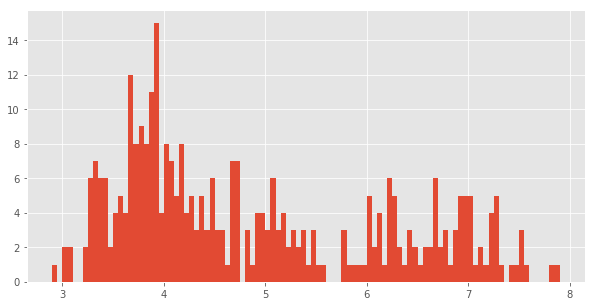

In [224]:
plt.hist(corn_prices['Crude Rate'],bins=100)

#### Visualizing Corn prices for states

Text(0.5,1,'Corn Prices 2011-17')

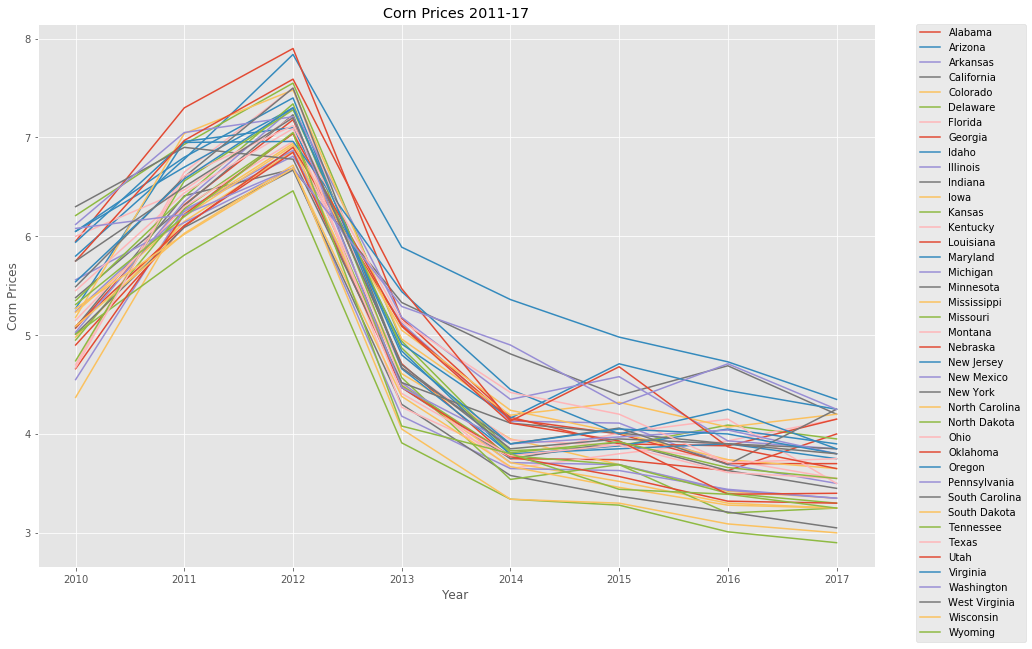

In [372]:
plot_all_states(corn_prices)
plt.xlabel("Year")
plt.ylabel('Corn Prices')
plt.title("Corn Prices 2011-17")

In [255]:
obesity_hypothesis = obesity_us[obesity_us['QuestionID'] == 'Q036'].loc[:,['YearStart', 'LocationDesc', 'Data_Value']]

In [267]:
obesity_hypothesis.columns = ['Year', 'State', 'Crude Rate']
obesity_hypothesis['State'] = obesity_hypothesis['State'].apply(lambda x: x.upper())
obesity_hypothesis.head()
obesity_hypothesis.dtypes

Year            int64
State          object
Crude Rate    float64
dtype: object

In [268]:
corn_prices.head()
corn_prices.dtypes

Year            int64
State          object
Crude Rate    float64
dtype: object

In [364]:
df_hyp1 = pd.merge(obesity_hypothesis, corn_prices, how='inner',on=['Year', 'State'])
df_hyp1
linregress(df_hyp1['Crude Rate_y'], df_hyp1['Crude Rate_x'])
# linregress(df_hyp1[df_hyp1['State'] == 'Alabama']['Crude Rate_x'], df_hyp1[df_hyp1['State'] == 'Alabama']['Crude Rate_y'])

LinregressResult(slope=-0.6712310777406808, intercept=32.871051260496607, rvalue=-0.2738399862372638, pvalue=1.3203640324917779e-05, stderr=0.15092246244460583)

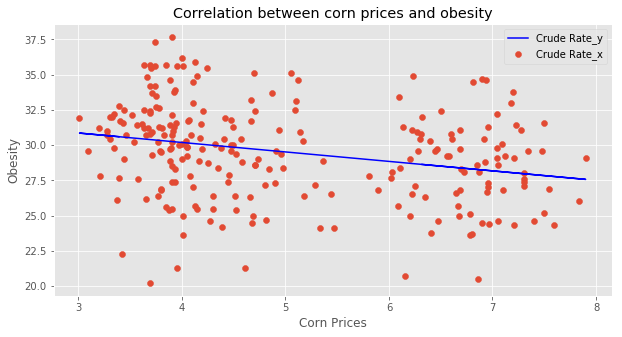

In [369]:
from scipy.stats import linregress
linregress
plt.scatter(df_hyp1['Crude Rate_y'], df_hyp1['Crude Rate_x'])
plt.plot(df_hyp1['Crude Rate_y'], -0.6712310777406808*df_hyp1['Crude Rate_y'] + 32.871051260496607, '-', color='blue')
plt.xlabel("Corn Prices")
plt.ylabel("Obesity")
plt.title("Correlation between corn prices and obesity")
plt.legend()

In [344]:
max_cr = max(obesity_hypothesis['Crude Rate'])
min_cr = 0
obesity_hypothesis['State'] = obesity_hypothesis['State'].apply(lambda x: x.title())
plot_on_map_with_slider(obesity_hypothesis,max_cr, min_cr)
# obesity_hypothesis